In [47]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import pickle
import time


import src.tools as tools
import src.recencytools as recency
import src.postprocess as postprocess
import src.preprocess as preprocess
import src.tfidftools as tfidftools
import src.scoring as scoring

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
path_to_data = 'data/'

training = pd.read_csv(path_to_data + 'training_set.csv', sep=',', header=0)

training_info = pd.read_csv(
    path_to_data + 'training_info.csv', sep=',', parse_dates=True, header=0)

test = pd.read_csv(path_to_data + 'test_set.csv', sep=',', header=0)

test_info = pd.read_csv(path_to_data + 'test_info.csv',
                        sep=',', parse_dates=True, header=0)

path_to_results = 'results/'

In [3]:
training_info = recency.add_time_rank_to_dataframe(training_info) # Run only once !

In [4]:
test_info = recency.add_time_rank_to_dataframe(test_info) # Run only once !

In [5]:
training

,sender,mids
0,karen.buckley@enron.com,158713 158697 200301 158679 278595 298162 2002...
1,amr.ibrahim@enron.com,215241 3437 215640 3506 191790 3517 3520 3562 ...
2,andrea.ring@enron.com,270705 270706 270707 270708 270709 270710 2707...
3,sylvia.hu@enron.com,111444 111422 183084 111412 111347 110883 1105...
4,phillip.platter@enron.com,327074 327384 327385 264443 274124 274125 2741...
5,richard.shapiro@enron.com,119822 125344 120633 323342 323343 119762 1203...
6,megan.parker@enron.com,361536 361285 358251 358253 358254 358255 3582...
7,david.forster@enron.com,17976 17969 17967 17966 18142 17965 17955 1795...
8,mike.maggi@enron.com,330758 330578 287305 287306 287307 287460 2874...
9,justin.rostant@enron.com,396265 10683 252783 252782 10631 156898 252121...


In [22]:
val_info

,mid,date,body,recipients,parsed_date,time_rank
22323,190751,2001-10-25 10:44:21,Who should go to the fundraiser on my behalf w...,richard.shapiro@enron.com,2001-10-25 10:44:21,2181.0
4873,41554,2001-10-25 10:45:52,--------------------------Sent from my BlackBe...,connie.hook@enron.com,2001-10-25 10:45:52,2180.0
1749,28352,2001-10-25 10:57:50,Anytime.,paul.miller@enron.com,2001-10-25 10:57:50,2179.0
38763,365329,2001-10-25 11:02:15,-----Original Message-----From: \tChuck carso...,hhill@houston.rr.com,2001-10-25 11:02:15,2178.0
8424,79942,2001-10-25 11:05:11,"Jeff,Ellen Su and I are working on it for toda...",gary.hickerson@enron.com a..price@enron.com je...,2001-10-25 11:05:11,2177.0
43602,404466,2001-10-25 11:06:34,"If you work in West Power Trading, congratulat...",john.anderson@enron.com caroline.emmert@enron....,2001-10-25 11:06:34,2175.5
29253,269206,2001-10-25 11:06:34,X-FileName: holden salisbury 6-26-02.PSTIf you...,john.anderson@enron.com caroline.emmert@enron....,2001-10-25 11:06:34,2175.5
23811,205129,2001-10-25 11:08:54,Sue -Received your voice mail. Having AReM on...,susan.mara@enron.com jeff.dasovich@enron.com,2001-10-25 11:08:54,2173.5
5936,49809,2001-10-25 11:08:54,Sue -Received your voice mail. Having AReM on...,susan.mara@enron.com jeff.dasovich@enron.com,2001-10-25 11:08:54,2173.5
5935,49808,2001-10-25 11:18:21,FYI. You may want to send out to RTO team.Jim...,janel.guerrero@enron.com,2001-10-25 11:18:21,2172.0


In [6]:
test_info

,mid,date,body,parsed_date,time_rank
1739,284098,2001-11-02 05:25:29,"How is everyone.....mother, child.........fath...",2001-11-02 05:25:29,2362.0
1598,272008,2001-11-02 05:34:55,-----Original Message-----From: \tWesner-Soon...,2001-11-02 05:34:55,2361.0
343,49273,2001-11-02 05:57:55,Janine -Ok for you to cover the whole country....,2001-11-02 05:57:55,2360.0
494,71901,2001-11-02 06:10:47,when?,2001-11-02 06:10:47,2359.0
562,82354,2001-11-02 06:17:44,WOW.... I am positive that your beautiful wife...,2001-11-02 06:17:44,2358.0
561,82353,2001-11-02 06:26:44,Info... -----Original Message-----From: \tLe ...,2001-11-02 06:26:44,2357.0
1293,207543,2001-11-02 06:29:14,"Charles Schwab & Co., Inc.Email AlertMorning M...",2001-11-02 06:29:14,2356.0
698,101120,2001-11-02 06:40:07,Chuck -I will finalize the agreement this morn...,2001-11-02 06:40:07,2355.0
360,50955,2001-11-02 06:48:19,"jim, he took at the CYA footnote. it was a joke.",2001-11-02 06:48:19,2354.0
354,50917,2001-11-02 06:48:56,I m on it.,2001-11-02 06:48:56,2353.0


In [42]:
train_info, train_email_ids_per_sender, val_info, val_email_ids_per_sender = scoring.get_train_val(training, training_info, train_frac=0.95)

Processing training !
processed 0 senders
processed 20 senders
processed 40 senders
processed 60 senders
processed 80 senders
processed 100 senders
processed 120 senders
Processing val !
processed 0 senders
processed 20 senders
processed 40 senders
processed 60 senders
processed 80 senders
processed 100 senders
processed 120 senders


In [58]:
scores = []
time_constants = [1000, 3000, 4000, 5000, 7000]
for beta_val in time_constants:
    print('time constant : {beta}'.format(beta=beta_val))
    recency_address_books = recency.get_recency_address_books(train_email_ids_per_sender, train_info, beta_val)
    recency_predictions = recency.predictions_from_addressbook(val_email_ids_per_sender, recency_address_books)
    recency_predictions = recency.recency_predictions_to_standard(recency_predictions)
    current_score = scoring.compute_prediction_mad(recency_predictions, val_info)
    scores.append(current_score)
    print(scores)

time constant : 1000
processed 0 senders
processed 10 senders
processed 20 senders
processed 30 senders
processed 40 senders
processed 50 senders
processed 60 senders
processed 70 senders
processed 80 senders
processed 90 senders
processed 100 senders
processed 110 senders
processed 120 senders
[0.32625701620502501]
time constant : 3000
processed 0 senders
processed 10 senders
processed 20 senders
processed 30 senders
processed 40 senders
processed 50 senders
processed 60 senders
processed 70 senders
processed 80 senders
processed 90 senders
processed 100 senders
processed 110 senders
processed 120 senders
[0.32625701620502501, 0.33918930940776809]
time constant : 4000
processed 0 senders
processed 10 senders
processed 20 senders
processed 30 senders
processed 40 senders
processed 50 senders
processed 60 senders
processed 70 senders
processed 80 senders
processed 90 senders
processed 100 senders
processed 110 senders
processed 120 senders
[0.32625701620502501, 0.33918930940776809, 0.34

In [55]:
best_local_time = 4000
max_kept_recipients = 30
recency_address_books = recency.get_recency_address_books(train_email_ids_per_sender, train_info, best_local_time)
recency_predictions = recency.predictions_from_addressbook(val_email_ids_per_sender, recency_address_books, k=max_kept_recipients)
recency_predictions = recency.recency_predictions_to_standard(recency_predictions)
current_score = scoring.compute_prediction_mad(recency_predictions, val_info)

processed 0 senders
processed 10 senders
processed 20 senders
processed 30 senders
processed 40 senders
processed 50 senders
processed 60 senders
processed 70 senders
processed 80 senders
processed 90 senders
processed 100 senders
processed 110 senders
processed 120 senders


In [56]:
current_score

0.34212073345479277

In [57]:
path_to_ranks = 'ranks_val/recency-beta-{beta}-rec-{rec_nb}'.format(beta=best_local_time,
                                                                   rec_nb=max_kept_recipients)
with open(path_to_ranks, 'wb') as infile:
          pickle.dump(recency_predictions, infile)

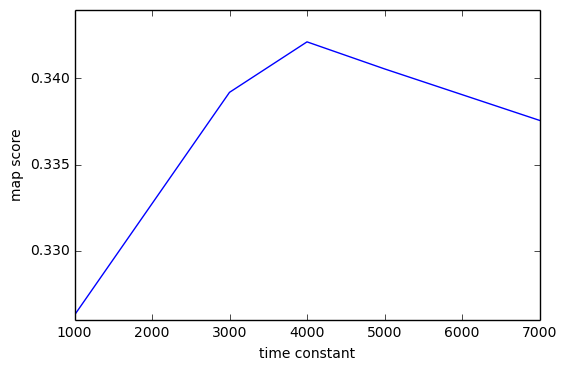

In [60]:
plt.plot(time_constants, scores)
plt.xlabel('time constant')
plt.ylabel('map score')
plt.show()